In [1]:
#Import modules #Run this once

import numpy as np
import pandas as pd
import os.path
from pylab import *
import glob
import os
import re
from xlwt import Workbook
from scipy.optimize import curve_fit
global pointnumber
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model, Parameter, Parameters
import matplotlib.pyplot as plt

%matplotlib inline

In [301]:
ton = 1;
toff = 10;
on_rand_exp = np.random.exponential(ton*10,1000)
on_rand_exp = np.round(on_rand_exp)
off_rand_exp = np.random.exponential(toff*10,1000)
off_rand_exp = np.round(off_rand_exp)

intensity = []
for i in range(len(off_rand_exp)):
    #on-times
    ran_on = randn(on_rand_exp[i])
    intensity_on = 2500 * np.ones(on_rand_exp[i])
    intensity_on = intensity_on + intensity_on *0.05*ran_on
    intensity = np.concatenate((intensity, intensity_on), axis=0)
    #off time
    ran_off = 3 + randn(off_rand_exp[i])
    intensity_off = 200 * np.ones(off_rand_exp[i])
    intensity_off = intensity_off + intensity_off*0.25*ran_off
    intensity = np.concatenate((intensity, intensity_off), axis=0)
time = linspace(0, len(intensity), len(intensity)+1)

/home/biswajit/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/biswajit/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/home/biswajit/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 3138.9928556497985)

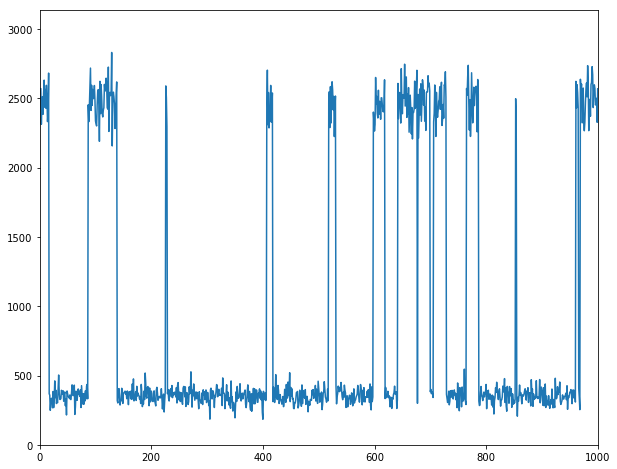

In [303]:
figure(figsize=(10, 8))
plot(time[:-1], intensity)
xlim(0, 1000)
ylim(0, None)

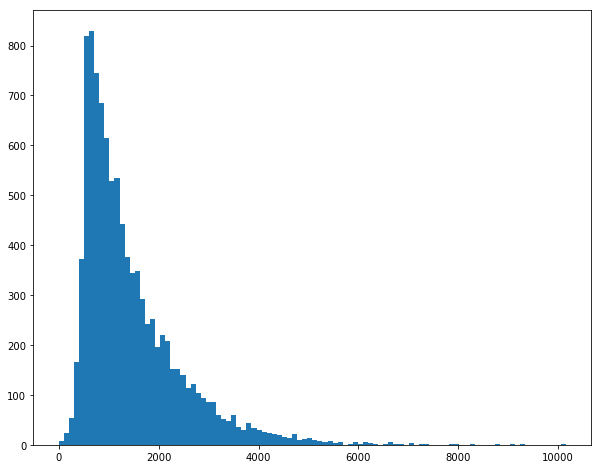

In [361]:
toff1 = 1;
toff2 = 10;
multiplier = 100
off_exp1 = np.random.exponential(toff1*multiplier,10000)
off_exp1 = np.round(off_exp1)
off_exp2 = np.random.exponential(toff2*multiplier,10000)
off_exp2 = np.round(off_exp2)
off_biexp = off_exp2 - off_exp1
figure(figsize=(10, 8))
hist(off_biexp - min(off_biexp), bins=100);